In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import scipy
from sklearn.model_selection import GroupKFold
from sklearn import linear_model
from lineartree import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
def rae(actual, predicted):
    numerator = np.sum(np.abs(predicted - actual))
    denominator = np.sum(np.abs(np.mean(actual) - actual))
    return numerator / denominator

In [3]:
def peak_eV_nm(peak_eV):
    return 1239.84193/peak_eV

In [4]:
def FWHM_eV_nm(peak_eV,fwhm_eV):
    return  2*(1239.84193/(peak_eV-fwhm_eV/2) - 1239.84193/(peak_eV))

In [5]:
#Test Linear Regression on Train/Val set, 10-fold cross validation (Group splits), UV Peak, FWHM (eV), Normalized
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random forest regression models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 12, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=15, 
                                       min_samples_split = 4, 
                                       min_samples_leaf = 1, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth= 18, 
                                       min_samples_split = 3, 
                                       min_samples_leaf = 1, 
                                       max_features = 5,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

#Split groups for cross validation by Experiment number
gkf = GroupKFold(n_splits=10)
matrix = np.zeros([10,13])
matrix_fwhm = np.zeros([10,13])
matrix_cascade = np.zeros([10,14])

j = 0
#Loop through the 10 splits
for train_index, test_index in gkf.split(X, groups=group):
    #Separate out training and test sets
    X_train = X.iloc[train_index, :]
    X2_train = X2.iloc[train_index, :]
    y_train = y[train_index]
    z_train = z[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    z_test = z[test_index]

    #prediction for Peak
    regressor_peak.fit(X_train, y_train)
    y_pred = regressor_peak.predict(X_test)
    #prediction for FWHM (direct)
    regressor_fwhm.fit(X_train, z_train)
    y_pred_fwhm = regressor_fwhm.predict(X_test)
    #prediction for FWHM (cascade)
    regressor_cascade.fit(X2_train, z_train)
    X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
    y_pred_cascade = regressor_cascade.predict(X_test)

    #errors in eV (normalized)
    
    #UN-normalize eV predictions by scaling with ratio

    ratio = (1239.84193/400 - 1239.84193/620)
    ratio2 = 0.35
    matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
    matrix[j,1] = metrics.r2_score(y_test, y_pred)
    matrix[j,2] = rae(y_test, y_pred)
    matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
    matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
    matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
    matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

    matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
    matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
    matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
    matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

    #errors in nm
    #UNnormalize the data first
    y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    z_test = z_test*(0.35)+0.05
    y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
    y_pred_cascade = y_pred_cascade*(0.35)+0.05
    
    #Calculate data in nm and eV
    matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
    matrix[j,8:13] = regressor_peak.feature_importances_

    matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
    matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

    matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
    matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

    j+=1

matrix_2 = np.zeros([1,21])
matrix_2[0,:8] = matrix.mean(0)[:8]
matrix_2[0,8:16] = np.std(matrix[:,:8], axis=0)
matrix_2[0,16:21] = matrix.mean(0)[8:13]

matrix_3 = np.zeros([1,21])
matrix_3[0,:8] = matrix_fwhm.mean(0)[:8]
matrix_3[0,8:16] = np.std(matrix_fwhm[:,:8], axis=0)
matrix_3[0,16:21] = matrix_fwhm.mean(0)[8:13]

matrix_4 = np.zeros([1,22])
matrix_4[0,:8] = matrix_cascade.mean(0)[:8]
matrix_4[0,8:16] = np.std(matrix_cascade[:,:8], axis=0)
matrix_4[0,16:22] = matrix_cascade.mean(0)[8:14]

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV): \t", "{:.4f}".format(matrix_2[0,0]), "{:.4f}".format(matrix_2[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_2[0,1]), "{:.4f}".format(matrix_2[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_2[0,2]), "{:.4f}".format(matrix_2[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_2[0,3]), "{:.4f}".format(matrix_2[0,11]))
print("Importances\t", matrix_2[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_2[0,4]), "{:.4f}".format(matrix_2[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_2[0,5]), "{:.4f}".format(matrix_2[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_2[0,6]), "{:.4f}".format(matrix_2[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_2[0,7]), "{:.4f}".format(matrix_2[0,15]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_3[0,0]), "{:.4f}".format(matrix_3[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_3[0,1]), "{:.4f}".format(matrix_3[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_3[0,2]), "{:.4f}".format(matrix_3[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_3[0,3]), "{:.4f}".format(matrix_3[0,11]))
print("Importances\t", matrix_3[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_3[0,4]), "{:.4f}".format(matrix_3[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_3[0,5]),"{:.4f}".format(matrix_3[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_3[0,6]), "{:.4f}".format(matrix_3[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_3[0,7]), "{:.4f}".format(matrix_3[0,15]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_4[0,0]), "{:.4f}".format(matrix_4[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_4[0,1]), "{:.4f}".format(matrix_4[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_4[0,2]), "{:.4f}".format(matrix_4[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_4[0,3]), "{:.4f}".format(matrix_4[0,11]))
print("Importances\t", matrix_4[0,16:22])
print("MAE (nm):\t","{:.4f}".format(matrix_4[0,4]), "{:.4f}".format(matrix_4[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_4[0,5]),"{:.4f}".format(matrix_4[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_4[0,6]), "{:.4f}".format(matrix_4[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_4[0,7]), "{:.4f}".format(matrix_4[0,15]))

np.savetxt("RF_UV_Val_peak.csv", matrix, delimiter=",")
np.savetxt("RF_UV_Val_fwhm.csv", matrix_fwhm, delimiter=",")
np.savetxt("RF_UV_Val_cascade.csv", matrix_cascade, delimiter=",")

Absorbance Peak
MAE (eV): 	 0.0554 0.0045
R2 (eV):	 0.8555 0.0292
RAE (eV):	 0.3566 0.0384
RMSE (eV):	 0.0710 0.0060
Importances	 [0.13143 0.16967 0.21065 0.07897 0.40928]
MAE (nm):	 11.8126 0.9169
R2 (nm):	 0.8459 0.0340
RAE (nm):	 0.3632 0.0397
RMSE (nm):	 15.1962 1.4035
Absorbance FWHM (direct)
MAE (eV):	 0.0084 0.0007
R2 (eV):	 0.7260 0.0701
RAE (eV):	 0.4218 0.0373
RMSE (eV):	 0.0131 0.0023
Importances	 [0.12562 0.19818 0.20686 0.15523 0.31411]
MAE (nm):	 2.6276 0.1985
R2 (nm):	 0.6700 0.0679
RAE (nm):	 0.4950 0.0503
RMSE (nm):	 3.7122 0.5258
Absorbance FWHM (cascade)
MAE (eV):	 0.0083 0.0007
R2 (eV):	 0.7250 0.0813
RAE (eV):	 0.4148 0.0386
RMSE (eV):	 0.0131 0.0025
Importances	 [0.08213 0.15257 0.18502 0.11795 0.22573 0.23661]
MAE (nm):	 2.5544 0.2140
R2 (nm):	 0.6728 0.0751
RAE (nm):	 0.4805 0.0454
RMSE (nm):	 3.7010 0.6242


In [6]:
#Test Linear Regression on Train/Val set, 10-fold cross validation (Group splits), PL Peak, FWHM (eV), Normalized
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random Forest models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 11, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=19, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth=19, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

#Split groups for cross validation by Experiment number
gkf = GroupKFold(n_splits=10)
matrix = np.zeros([10,13])
matrix_fwhm = np.zeros([10,13])
matrix_cascade = np.zeros([10,14])

j = 0
#Loop through the 10 splits
for train_index, test_index in gkf.split(X, groups=group):
    #Separate out training and test sets
    X_train = X.iloc[train_index, :]
    X2_train = X2.iloc[train_index, :]
    y_train = y[train_index]
    z_train = z[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    z_test = z[test_index]

    #prediction for Peak
    regressor_peak.fit(X_train, y_train)
    y_pred = regressor_peak.predict(X_test)
    #prediction for FWHM (direct)
    regressor_fwhm.fit(X_train, z_train)
    y_pred_fwhm = regressor_fwhm.predict(X_test)
    #prediction for FWHM (cascade)
    regressor_cascade.fit(X2_train, z_train)
    X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
    y_pred_cascade = regressor_cascade.predict(X_test)

    #errors in eV (normalized)
    
    #UN-normalize eV predictions by scaling with ratio

    ratio = (1239.84193/400 - 1239.84193/620)
    ratio2 = 0.35
    matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
    matrix[j,1] = metrics.r2_score(y_test, y_pred)
    matrix[j,2] = rae(y_test, y_pred)
    matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
    matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
    matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
    matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

    matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
    matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
    matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
    matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

    #errors in nm
    #UNnormalize the data first
    y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    z_test = z_test*(0.35)+0.05
    y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
    y_pred_cascade = y_pred_cascade*(0.35)+0.05
    
    #Calculate data in nm and eV
    matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
    matrix[j,8:13] = regressor_peak.feature_importances_

    matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
    matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

    matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
    matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

    j+=1

matrix_2 = np.zeros([1,21])
matrix_2[0,:8] = matrix.mean(0)[:8]
matrix_2[0,8:16] = np.std(matrix[:,:8], axis=0)
matrix_2[0,16:21] = matrix.mean(0)[8:13]

matrix_3 = np.zeros([1,21])
matrix_3[0,:8] = matrix_fwhm.mean(0)[:8]
matrix_3[0,8:16] = np.std(matrix_fwhm[:,:8], axis=0)
matrix_3[0,16:21] = matrix_fwhm.mean(0)[8:13]

matrix_4 = np.zeros([1,22])
matrix_4[0,:8] = matrix_cascade.mean(0)[:8]
matrix_4[0,8:16] = np.std(matrix_cascade[:,:8], axis=0)
matrix_4[0,16:22] = matrix_cascade.mean(0)[8:14]

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_2[0,0]), "{:.4f}".format(matrix_2[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_2[0,1]), "{:.4f}".format(matrix_2[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_2[0,2]), "{:.4f}".format(matrix_2[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_2[0,3]), "{:.4f}".format(matrix_2[0,11]))
print("Importances\t", matrix_2[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_2[0,4]), "{:.4f}".format(matrix_2[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_2[0,5]), "{:.4f}".format(matrix_2[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_2[0,6]), "{:.4f}".format(matrix_2[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_2[0,7]), "{:.4f}".format(matrix_2[0,15]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_3[0,0]), "{:.4f}".format(matrix_3[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_3[0,1]), "{:.4f}".format(matrix_3[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_3[0,2]), "{:.4f}".format(matrix_3[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_3[0,3]), "{:.4f}".format(matrix_3[0,11]))
print("Importances\t", matrix_3[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_3[0,4]), "{:.4f}".format(matrix_3[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_3[0,5]),"{:.4f}".format(matrix_3[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_3[0,6]), "{:.4f}".format(matrix_3[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_3[0,7]), "{:.4f}".format(matrix_3[0,15]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_4[0,0]), "{:.4f}".format(matrix_4[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_4[0,1]), "{:.4f}".format(matrix_4[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_4[0,2]), "{:.4f}".format(matrix_4[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_4[0,3]), "{:.4f}".format(matrix_4[0,11]))
print("Importances\t", matrix_4[0,16:22])
print("MAE (nm):\t","{:.4f}".format(matrix_4[0,4]), "{:.4f}".format(matrix_4[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_4[0,5]),"{:.4f}".format(matrix_4[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_4[0,6]), "{:.4f}".format(matrix_4[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_4[0,7]), "{:.4f}".format(matrix_4[0,15]))

np.savetxt("RF_PL_Val_peak.csv", matrix, delimiter=",")
np.savetxt("RF_PL_Val_fwhm.csv", matrix_fwhm, delimiter=",")
np.savetxt("RF_PL_Val_cascade.csv", matrix_cascade, delimiter=",")

Emission Peak
MAE (eV):	 0.0523 0.0018
R2 (eV):	 0.8320 0.0192
RAE (eV):	 0.3918 0.0262
RMSE (eV):	 0.0662 0.0021
Importances	 [0.12572 0.18312 0.25145 0.08468 0.35502]
MAE (nm):	 11.8968 0.4029
R2 (nm):	 0.8272 0.0205
RAE (nm):	 0.3958 0.0283
RMSE (nm):	 14.9761 0.4456
Emission FWHM (direct)
MAE (eV):	 0.0081 0.0007
R2 (eV):	 0.6618 0.0842
RAE (eV):	 0.4979 0.0468
RMSE (eV):	 0.0121 0.0014
Importances	 [0.14959 0.1871  0.165   0.15319 0.34511]
MAE (nm):	 2.5021 0.1040
R2 (nm):	 0.6619 0.0699
RAE (nm):	 0.5397 0.0414
RMSE (nm):	 3.4221 0.1904
Emission FWHM (cascade)
MAE (eV):	 0.0078 0.0007
R2 (eV):	 0.6786 0.0795
RAE (eV):	 0.4827 0.0402
RMSE (eV):	 0.0118 0.0014
Importances	 [0.11385 0.12158 0.13986 0.12869 0.22296 0.27305]
MAE (nm):	 2.4451 0.1081
R2 (nm):	 0.6735 0.0674
RAE (nm):	 0.5273 0.0396
RMSE (nm):	 3.3639 0.1986


In [7]:
#Train model on entire dataset (Absorbance)
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random forest regression models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 12, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=15, 
                                       min_samples_split = 4, 
                                       min_samples_leaf = 1, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth= 18, 
                                       min_samples_split = 3, 
                                       min_samples_leaf = 1, 
                                       max_features = 5,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
y_test = y
z_test = z
j=0

#prediction for Peak
regressor_peak.fit(X_train, y_train)
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
regressor_fwhm.fit(X_train, z_train)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
regressor_cascade.fit(X2_train, z_train)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
matrix[j,8:13] = regressor_peak.feature_importances_

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Training Accuracy' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("Importances\t", matrix[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("Importances\t", matrix_fwhm[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("Importances\t", matrix_cascade[0,8:14])
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

Absorption Peak/FWHM Training Accuracy
Absorbance Peak
MAE (eV):	 0.0363
R2 (eV):	 0.9415
RAE (eV):	 0.2311
RMSE (eV):	 0.0460
Importances	 [0.13187 0.16849 0.21245 0.07994 0.40724]
MAE (nm):	 7.8428
R2 (nm):	 0.9347
RAE (nm):	 0.2383
RMSE (nm):	 10.0551
Absorbance FWHM (direct)
MAE (eV):	 0.0044
R2 (eV):	 0.9131
RAE (eV):	 0.2205
RMSE (eV):	 0.0075
Importances	 [0.12663 0.19877 0.20597 0.15748 0.31114]
MAE (nm):	 1.5126
R2 (nm):	 0.8924
RAE (nm):	 0.2791
RMSE (nm):	 2.1560
Absorbance FWHM (cascade)
MAE (eV):	 0.0052
R2 (eV):	 0.8527
RAE (eV):	 0.2588
RMSE (eV):	 0.0097
Importances	 [0.08096 0.15448 0.18654 0.1201  0.22477 0.23315]
MAE (nm):	 1.6643
R2 (nm):	 0.8382
RAE (nm):	 0.3071
RMSE (nm):	 2.6445


In [8]:
#Test Linear model on interpolation, UV Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe UV Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Interpolation' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_UV_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_UV_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_UV_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Interpolation
Absorbance Peak
MAE (eV):	 0.0562
R2 (eV):	 0.7940
RAE (eV):	 0.4271
RMSE (eV):	 0.0718
MAE (nm):	 11.5082
R2 (nm):	 0.8130
RAE (nm):	 0.4081
RMSE (nm):	 14.3954
Absorbance FWHM (direct)
MAE (eV):	 0.0124
R2 (eV):	 0.5782
RAE (eV):	 0.6235
RMSE (eV):	 0.0160
MAE (nm):	 2.3660
R2 (nm):	 0.7112
RAE (nm):	 0.4388
RMSE (nm):	 3.3884
Absorbance FWHM (cascade)
MAE (eV):	 0.0114
R2 (eV):	 0.6588
RAE (eV):	 0.5729
RMSE (eV):	 0.0144
MAE (nm):	 2.1896
R2 (nm):	 0.7710
RAE (nm):	 0.4061
RMSE (nm):	 3.0174


In [9]:
#Test Linear model on extrapolation, UV Peak, FWHM (eV)

#Test data set (extrapolation)
df2 = pd.read_csv('CdSe UV Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Extrapolation' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_UV_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_UV_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_UV_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Extrapolation
Absorbance Peak
MAE (eV):	 0.0425
R2 (eV):	 0.9253
RAE (eV):	 0.2566
RMSE (eV):	 0.0544
MAE (nm):	 8.8980
R2 (nm):	 0.9276
RAE (nm):	 0.2512
RMSE (nm):	 11.2618
Absorbance FWHM (direct)
MAE (eV):	 0.0119
R2 (eV):	 0.7374
RAE (eV):	 0.4393
RMSE (eV):	 0.0162
MAE (nm):	 2.4504
R2 (nm):	 0.5626
RAE (nm):	 0.5428
RMSE (nm):	 3.4773
Absorbance FWHM (cascade)
MAE (eV):	 0.0111
R2 (eV):	 0.7851
RAE (eV):	 0.4093
RMSE (eV):	 0.0146
MAE (nm):	 2.3399
R2 (nm):	 0.6058
RAE (nm):	 0.5183
RMSE (nm):	 3.3011


In [10]:
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

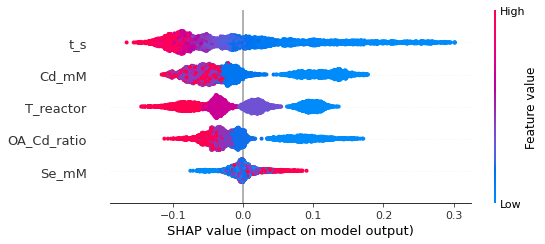

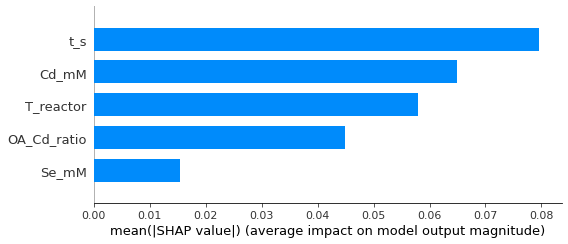

In [11]:
#SHAP on training data for Peak
import shap
tree_explainer = shap.TreeExplainer(regressor_peak)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")

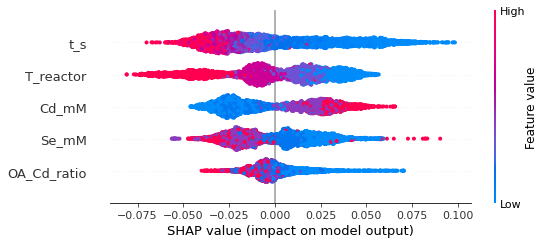

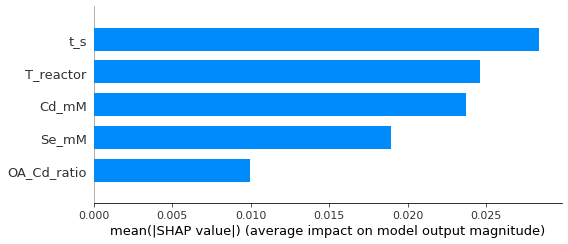

In [12]:
#SHAP on training data for FWHM
tree_explainer = shap.TreeExplainer(regressor_fwhm)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")

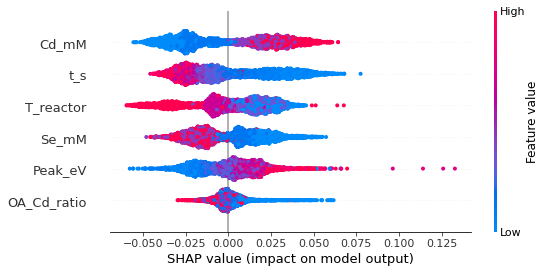

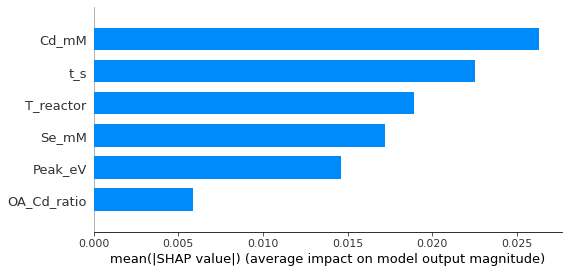

In [13]:
#SHAP on training data for Cascade
tree_explainer = shap.TreeExplainer(regressor_cascade)
shap_values = tree_explainer.shap_values(X2)
shap.summary_plot(shap_values, X2)
shap.summary_plot(shap_values, X2, plot_type="bar")

In [14]:
#Train model on entire dataset (Emission)
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random Forest models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 11, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=19, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth=19, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
y_test = y
z_test = z
j=0

#prediction for Peak
regressor_peak.fit(X_train, y_train)
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
regressor_fwhm.fit(X_train, z_train)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
regressor_cascade.fit(X2_train, z_train)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
matrix[j,8:13] = regressor_peak.feature_importances_

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Training Accuracy' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("Importances\t", matrix[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("Importances\t", matrix_fwhm[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("Importances\t", matrix_cascade[0,8:14])
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

Emission Peak/FWHM Training Accuracy
Emission Peak
MAE (eV):	 0.0371
R2 (eV):	 0.9192
RAE (eV):	 0.2728
RMSE (eV):	 0.0466
Importances	 [0.12369 0.18314 0.25536 0.08446 0.35336]
MAE (nm):	 8.5566
R2 (nm):	 0.9123
RAE (nm):	 0.2793
RMSE (nm):	 10.8332
Emission FWHM (direct)
MAE (eV):	 0.0040
R2 (eV):	 0.9120
RAE (eV):	 0.2426
RMSE (eV):	 0.0063
Importances	 [0.15117 0.19165 0.16512 0.15179 0.34028]
MAE (nm):	 1.4785
R2 (nm):	 0.8901
RAE (nm):	 0.3153
RMSE (nm):	 1.9949
Emission FWHM (cascade)
MAE (eV):	 0.0054
R2 (eV):	 0.8350
RAE (eV):	 0.3325
RMSE (eV):	 0.0086
Importances	 [0.1118  0.12297 0.1433  0.12942 0.2219  0.2706 ]
MAE (nm):	 1.7340
R2 (nm):	 0.8338
RAE (nm):	 0.3698
RMSE (nm):	 2.4532


In [15]:
#Test Linear model on interpolation, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Interpolation' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_PL_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_PL_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_PL_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Emission Peak/FWHM Interpolation
Emission Peak
MAE (eV):	 0.0517
R2 (eV):	 0.8039
RAE (eV):	 0.4298
RMSE (eV):	 0.0629
MAE (nm):	 11.3910
R2 (nm):	 0.8205
RAE (nm):	 0.4140
RMSE (nm):	 13.5878
Emission FWHM (direct)
MAE (eV):	 0.0108
R2 (eV):	 0.5317
RAE (eV):	 0.6345
RMSE (eV):	 0.0159
MAE (nm):	 2.6742
R2 (nm):	 0.6245
RAE (nm):	 0.5662
RMSE (nm):	 3.7219
Emission FWHM (cascade)
MAE (eV):	 0.0100
R2 (eV):	 0.5798
RAE (eV):	 0.5838
RMSE (eV):	 0.0151
MAE (nm):	 2.4685
R2 (nm):	 0.6689
RAE (nm):	 0.5227
RMSE (nm):	 3.4947


In [16]:
#Test Linear model on extrapolation, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Extrapolation' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_PL_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_PL_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_PL_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Emission Peak/FWHM Extrapolation
Emission Peak
MAE (eV):	 0.0386
R2 (eV):	 0.8856
RAE (eV):	 0.3118
RMSE (eV):	 0.0491
MAE (nm):	 8.7253
R2 (nm):	 0.8976
RAE (nm):	 0.2999
RMSE (nm):	 10.8389
Emission FWHM (direct)
MAE (eV):	 0.0096
R2 (eV):	 0.5901
RAE (eV):	 0.5491
RMSE (eV):	 0.0130
MAE (nm):	 2.4561
R2 (nm):	 0.4521
RAE (nm):	 0.6565
RMSE (nm):	 3.3088
Emission FWHM (cascade)
MAE (eV):	 0.0098
R2 (eV):	 0.5772
RAE (eV):	 0.5579
RMSE (eV):	 0.0132
MAE (nm):	 2.4984
R2 (nm):	 0.4375
RAE (nm):	 0.6678
RMSE (nm):	 3.3526


In [17]:
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

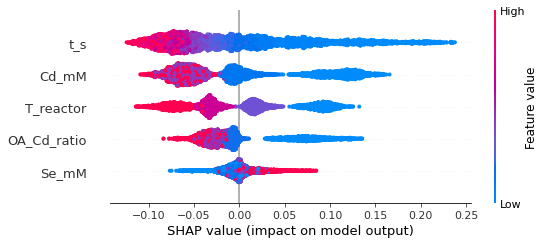

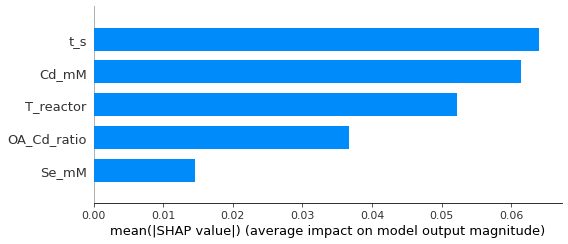

In [18]:
#SHAP on training data for Peak
import shap
tree_explainer = shap.TreeExplainer(regressor_peak)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")

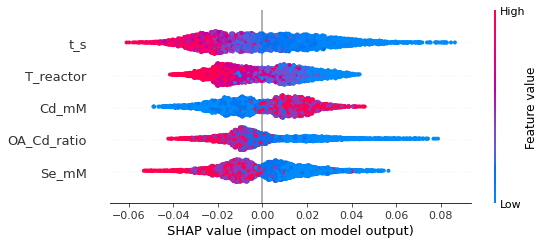

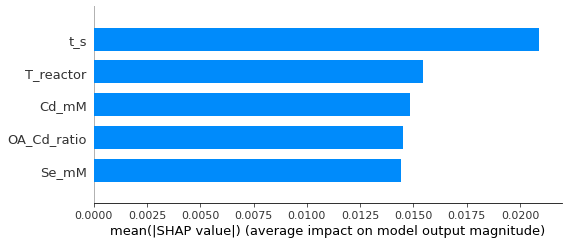

In [19]:
#SHAP on training data for FWHM
tree_explainer = shap.TreeExplainer(regressor_fwhm)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")

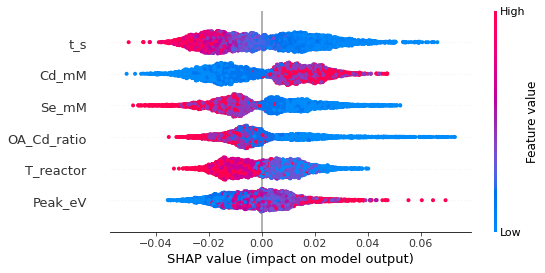

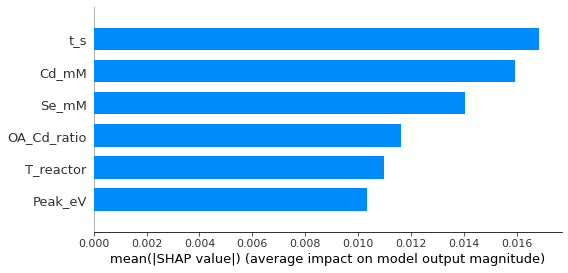

In [20]:
#SHAP on training data for FWHM (cascade)
tree_explainer = shap.TreeExplainer(regressor_cascade)
shap_values = tree_explainer.shap_values(X2)
shap.summary_plot(shap_values, X2)
shap.summary_plot(shap_values, X2, plot_type="bar")